**Importing Libraries and Datasets**

In [14]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Defining File Path for Analysis
filepath = '/content/drive/MyDrive/AOS C111 - Final Project Data/'


#Loading NOAA dataset (CSV)
noaa_path = filepath + 'NOAA_Precip_Jan1_2021_Sept18_2025.csv'
noaa_df = pd.read_csv(noaa_path)

#Loading UCLA FM data (Excel)
fm_path = filepath + 'UCLA_FM_WO_2021_Present.xlsx'
fm_df = pd.read_excel(fm_path)

#Previewing both datasets
#display(noaa_df.head())

#print("Facilities Management Data:")
#display(fm_df.head())

#Checking for column names and data types
#print("\nNOAA Columns:")
#print(noaa_df.columns)

#print("\nFM Columns:")
#print(fm_df.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


**Cleaning NOAA Data to pull precipitation and convert from mm to inches & filtering for non-zero values**

In [15]:
#converts mm to inches, heading first 30 days in dataset
noaa_df['PRCP_in'] = noaa_df['PRCP'] / 25.4
# Calculate log10 of precipitation, handling zero values by making them NaN
noaa_df['log10_PRCP_in'] = np.log10(noaa_df['PRCP_in'].replace(0, np.nan))
noaa_df[['DATE', 'PRCP', 'PRCP_in', 'log10_PRCP_in']].head(5) #change variable for number of rows want to view
noaa_df[noaa_df['PRCP_in'] > 0][['DATE', 'PRCP', 'PRCP_in', 'log10_PRCP_in']].head(10)

,DATE,PRCP,PRCP_in,log10_PRCP_in
22,2021-01-23,5.3,0.208661,-0.680558
23,2021-01-24,1.5,0.059055,-1.228742
24,2021-01-25,3.0,0.118110,-0.927712
28,2021-01-29,34.0,1.338583,0.126645
61,2021-03-03,1.8,0.070866,-1.149561
68,2021-03-10,12.2,0.480315,-0.318474
69,2021-03-11,6.9,0.271654,-0.565985
73,2021-03-15,6.4,0.251969,-0.598654
206,2021-07-26,3.0,0.118110,-0.927712
229,2021-08-18,0.8,0.031496,-1.501744


**Merging Dates of Precipitation to UCLA FM dataset**

In [16]:
noaa_df['DATE'] = pd.to_datetime(noaa_df['DATE'], errors='coerce')
noaa_df['DATE'].dtypes #checking

fm_df['Reported Date'] = pd.to_datetime(fm_df['Reported Date'], errors='coerce')
fm_df['Reported Date'].dtypes #checking

fm_df['DATE'] = fm_df['Reported Date'].dt.date
fm_df[['Reported Date', 'DATE']].head(10) #confirming

fm_df['DATE'] = pd.to_datetime(fm_df['DATE'], errors='coerce') #converting back for consistent merging

merged_df = pd.merge(
    fm_df,
    noaa_df[['DATE', 'PRCP_in', 'log10_PRCP_in']], # Include the new log10_PRCP_in column
    on='DATE',
    how='left'
)

print("Merged FM and NOAA dataset preview (first 30 rows):")
merged_df[['DATE', 'Reported Date', 'PRCP_in', 'log10_PRCP_in']].head(10)

rain_events_df = merged_df[merged_df['PRCP_in'] > 0].copy() #filtering out records with no rainfall or missing rainfall values


print("Filtered dataset (only days with nonzero precipitation):") #previews filtered dataset
rain_events_df[['DATE', 'Reported Date', 'PRCP_in', 'log10_PRCP_in']].head(10)

# Find the maximum recorded precipitation (in inches)
max_rain = rain_events_df['PRCP_in'].max()

print(f"The maximum recorded daily precipitation is {max_rain:.2f} inches.")

Merged FM and NOAA dataset preview (first 30 rows):
Filtered dataset (only days with nonzero precipitation):
The maximum recorded daily precipitation is 10.40 inches.


**Visualizing Timing of Work Orders over time**


### Visualizing Daily Work Orders and Cost Over Time

This plot displays the daily count of work orders and the daily total 'Cost To-Date' across the entire dataset (2021-2025), showing their trends over time. A dual Y-axis scatterplot is used to compare these two metrics effectively.

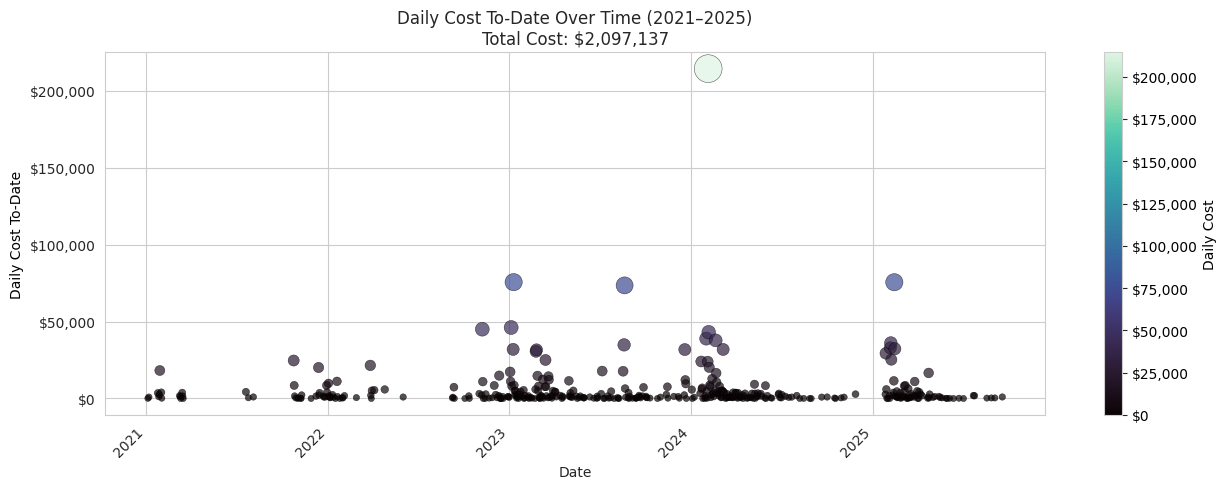

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

def dollar_format(x, pos):
    return f'${x:,.0f}'

sns.set_style("whitegrid")

daily_summary_data = merged_df.groupby('DATE').agg(
    daily_work_orders=('Work Order', 'count'),
    daily_cost=('Cost To-Date', 'sum')
).reset_index()

daily_summary_data['DATE'] = pd.to_datetime(daily_summary_data['DATE'])
daily_summary_data = daily_summary_data.sort_values('DATE')

total_cost = daily_summary_data['daily_cost'].sum()


fig, ax = plt.subplots(figsize=(13, 5))

#scatterplot, no seaborn legend
sns.scatterplot(
    x='DATE',
    y='daily_cost',
    data=daily_summary_data,
    hue='daily_cost',
    palette='mako',
    size='daily_cost',
    sizes=(20, 400),
    alpha=0.7,
    marker='o',
    edgecolor='black',
    legend=False,
    ax=ax
)

#y-axis formatting
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cost To-Date', color='black')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

plt.title(f'Daily Cost To-Date Over Time (2021–2025)\nTotal Cost: ${total_cost:,.0f}')
plt.xticks(rotation=45, ha='right')

#colorbar attached to this figure/axes
norm = plt.Normalize(daily_summary_data['daily_cost'].min(),
                     daily_summary_data['daily_cost'].max())
sm = plt.cm.ScalarMappable(norm=norm, cmap='mako')
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
cbar.set_label("Daily Cost", color='black')
cbar.ax.tick_params(labelcolor='black')

plt.tight_layout()
plt.show()



**Visualizing Work Orders by Precipitation Grouped by Month**

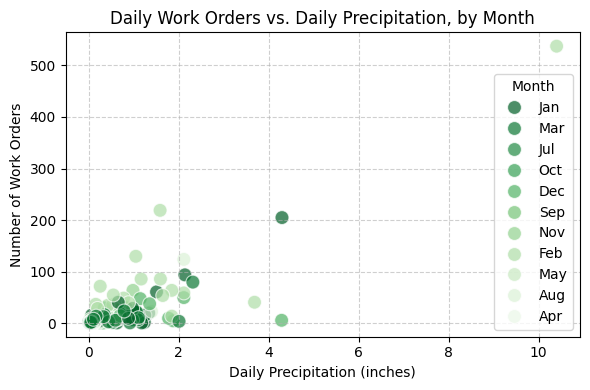

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import calendar

#Group by date to get daily work order count and daily precipitation total
daily_data = rain_events_df.groupby('DATE').agg(
    daily_work_orders=('Work Order', 'count'),
    daily_precipitation=('PRCP_in', 'first')
).reset_index()

# Extract month for color coordination
daily_data['Month'] = daily_data['DATE'].dt.month

# Map month numbers to month names for the legend (for all months)
daily_data['Month Name'] = daily_data['Month'].apply(lambda x: calendar.month_abbr[x])

# Create the scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='daily_precipitation',
    y='daily_work_orders',
    hue='Month Name',
    data=daily_data, # Use the full daily_data, not just seasonal
    palette='Greens_r',
    alpha=0.7,
    s=100
)

plt.title('Daily Work Orders vs. Daily Precipitation, by Month')
plt.xlabel('Daily Precipitation (inches)')
plt.ylabel('Number of Work Orders')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Month')
plt.tight_layout()
plt.show()

**Visualizing Work Orders by Precipitation (Log10) Grouped by Month**

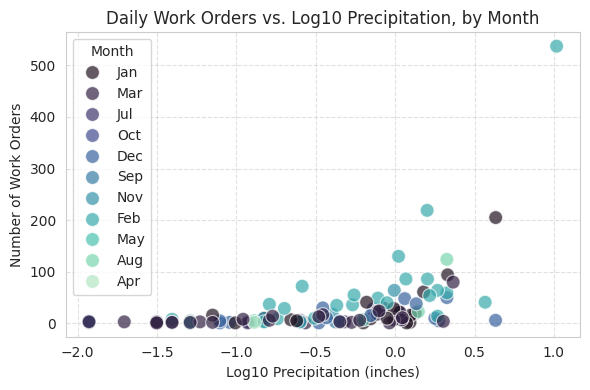

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

daily_data_log = rain_events_df.groupby('DATE').agg(
    daily_work_orders=('Work Order', 'count'),
    daily_log10_precipitation=('log10_PRCP_in', 'first') # Use the log10 value
).reset_index()

#Extract month for color coordination
daily_data_log['Month'] = daily_data_log['DATE'].dt.month

#Map month numbers to month names for the legend
daily_data_log['Month Name'] = daily_data_log['Month'].apply(lambda x: calendar.month_abbr[x])

# Create the scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='daily_log10_precipitation',
    y='daily_work_orders',
    hue='Month Name',
    data=daily_data_log,
    palette='mako',
    alpha=0.7,
    s=100
)

plt.title('Daily Work Orders vs. Log10 Precipitation, by Month')
plt.xlabel('Log10 Precipitation (inches)')
plt.ylabel('Number of Work Orders')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Month')
plt.tight_layout()
plt.show()

**Generating Distribution Curves for Precipitation**

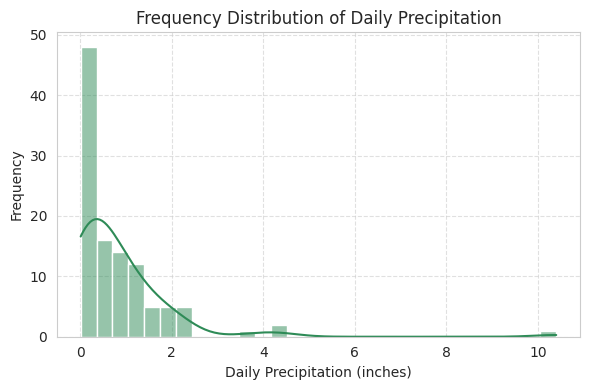

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

#Group by date to get daily work order count and daily precipitation total (PRCP_in)
#Using rain_events_df which already filters for PRCP_in > 0
daily_data_prcp = rain_events_df.groupby('DATE').agg(
    daily_work_orders=('Work Order', 'count'),
    daily_precipitation=('PRCP_in', 'first') # Use the original PRCP_in value
).reset_index()

#Histogram for the frequency of original precipitation (PRCP_in)
plt.figure(figsize=(6, 4))
sns.histplot(
    data=daily_data_prcp,
    x='daily_precipitation',
    bins=30, #Increased bins for potentially wider range of PRCP_in
    kde=True, #Add a Kernel Density Estimate
    color='seagreen'
)

plt.title('Frequency Distribution of Daily Precipitation')
plt.xlabel('Daily Precipitation (inches)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

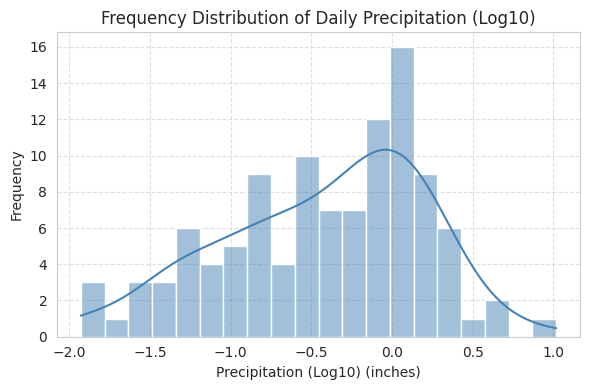

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

daily_data_log = rain_events_df.groupby('DATE').agg(
    daily_work_orders=('Work Order', 'count'),
    daily_log10_precipitation=('log10_PRCP_in', 'first') #Use the log10 value
).reset_index()

#Create a histogram for the frequency of log10 precipitation
plt.figure(figsize=(6, 4))
sns.histplot(
    data=daily_data_log,
    x='daily_log10_precipitation',
    bins=20,
    kde=True,
    color='steelblue'
)

plt.title('Frequency Distribution of Daily Precipitation (Log10)')
plt.xlabel('Precipitation (Log10) (inches)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Building Model DF**


In [81]:
#Build Modeling Dataset (one row per rainy day)
model_df = (
    rain_events_df.groupby('DATE')
    .agg(
        daily_work_orders=('Work Order', 'count'),
        PRCP_in=('PRCP_in', 'first'),
        log10_PRCP_in=('log10_PRCP_in', 'first')
    )
    .reset_index()
)

#Drop rows with missing or zero rainfall
model_df = model_df.dropna(subset=['log10_PRCP_in'])
model_df = model_df[model_df['PRCP_in'] > 0].copy()

#print(model_df.head())
#print(model_df.describe())


**Defining X and Y**

In [82]:
X = model_df[['log10_PRCP_in']]
y = model_df['daily_work_orders']


**Training/Test Splitting**

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


**Linear Regression - Baseline Model**

===== Linear Regression =====
Training RMSE: 35.408
Testing RMSE:  83.651
Training R²:   0.242
Testing R²:    0.176


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


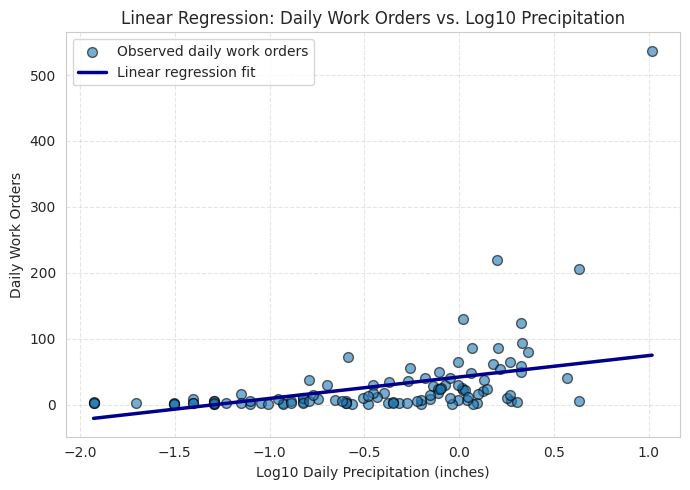

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#Initialize and fit the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

#Performance metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Output results
print("===== Linear Regression =====")
print(f"Training RMSE: {rmse_train:.3f}")
print(f"Testing RMSE:  {rmse_test:.3f}")
print(f"Training R²:   {r2_train:.3f}")
print(f"Testing R²:    {r2_test:.3f}")

#Use the full dataset for visualization
X_all = model_df[['log10_PRCP_in']]
y_all = model_df['daily_work_orders']

#Create smooth range of log10 precipitation values
x_min = model_df['log10_PRCP_in'].min()
x_max = model_df['log10_PRCP_in'].max()
x_plot = np.linspace(x_min, x_max, 200)

#Predict using the fitted linear model
y_plot_lin = lin_reg.predict(x_plot.reshape(-1, 1))

#Plot
plt.figure(figsize=(7, 5))

#Scatter of actual data
plt.scatter(
    model_df['log10_PRCP_in'],
    model_df['daily_work_orders'],
    alpha=0.6,
    edgecolor='k',
    s=50,
    label='Observed daily work orders'
)

#Linear regression line
plt.plot(
    x_plot,
    y_plot_lin,
    color='darkblue',
    linewidth=2.5,
    label='Linear regression fit'
)

plt.title('Linear Regression: Daily Work Orders vs. Log10 Precipitation')
plt.xlabel('Log10 Daily Precipitation (inches)')
plt.ylabel('Daily Work Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Ridge Regression**

===== Ridge Regression ====
Training RMSE: 35.414
Testing RMSE:  83.872
Training R²:   0.242
Testing R²:    0.171


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


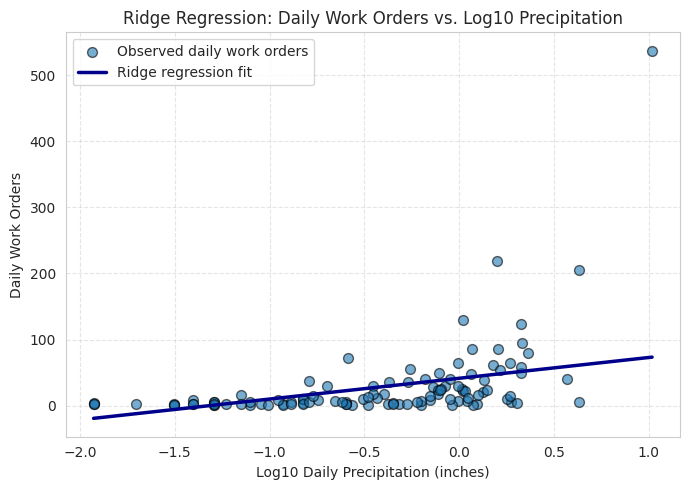

In [85]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and fit the Ridge model
ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X_train, y_train)

#Predictions
y_train_pred_ridge = ridge_reg.predict(X_train)
y_test_pred_ridge = ridge_reg.predict(X_test)

#Performance metrics
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

#Output results
print("===== Ridge Regression ====")
print(f"Training RMSE: {rmse_train_ridge:.3f}")
print(f"Testing RMSE:  {rmse_test_ridge:.3f}")
print(f"Training R²:   {r2_train_ridge:.3f}")
print(f"Testing R²:    {r2_test_ridge:.3f}")

#Create smooth range of log10 precipitation values
x_min = model_df['log10_PRCP_in'].min()
x_max = model_df['log10_PRCP_in'].max()
x_plot = np.linspace(x_min, x_max, 200)

#Predict using the already fitted Ridge model (which was trained on X_train, containing only 'log10_PRCP_in')
y_plot_ridge = ridge_reg.predict(x_plot.reshape(-1, 1))

#Plot
plt.figure(figsize=(7, 5))

#Scatter of actual data
plt.scatter(
    model_df['log10_PRCP_in'],
    model_df['daily_work_orders'],
    alpha=0.6,
    edgecolor='k',
    s=50,
    label='Observed daily work orders'
)

#Ridge regression line
plt.plot(
    x_plot,
    y_plot_ridge,
    color='darkblue',
    linewidth=2.5,
    label='Ridge regression fit'
)

plt.title('Ridge Regression: Daily Work Orders vs. Log10 Precipitation')
plt.xlabel('Log10 Daily Precipitation (inches)')
plt.ylabel('Daily Work Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Comparing Polynomial Regression Fits (Degrees 2-6)

This plot visualizes polynomial regression models with degrees from 2 to 6, overlaid on the scatter plot of daily work orders versus log10 precipitation. This helps in understanding how increasing the polynomial degree impacts the model's fit to the data.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


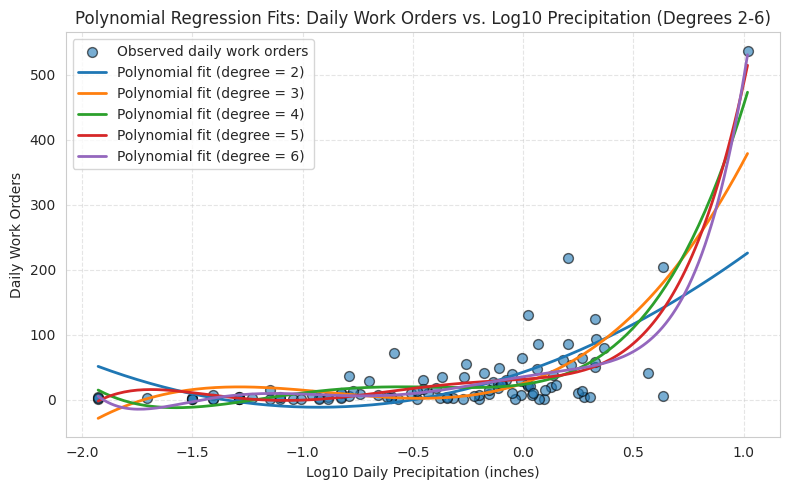

In [86]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

#Define the range of polynomial degrees to compare
degrees = range(2, 7) # Degrees 2, 3, 4, 5, 6

#Create smooth x-values for log10 precipitation for plotting
x_min = model_df['log10_PRCP_in'].min()
x_max = model_df['log10_PRCP_in'].max()
x_plot = np.linspace(x_min, x_max, 200).reshape(-1, 1)

plt.figure(figsize=(8, 5))

#Scatter plot of actual data (daily work orders vs. log10 precipitation)
plt.scatter(
    model_df['log10_PRCP_in'],
    model_df['daily_work_orders'],
    alpha=0.6,
    edgecolor='k',
    s=50,
    label='Observed daily work orders'
)

#Loop through each degree and plot the polynomial fit
for degree in degrees:
    #Build pipeline: PolynomialFeatures -> LinearRegression
    poly_model_comparison = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("linear", LinearRegression())
    ])

    #Fit the model to the full X, y data (for visualization)
    poly_model_comparison.fit(X, y)

    #Predict using the polynomial model for the current degree
    y_plot_degree = poly_model_comparison.predict(x_plot)

    #Plot the polynomial curve
    plt.plot(
        x_plot,
        y_plot_degree,
        linewidth=2,
        label=f'Polynomial fit (degree = {degree})'
    )

plt.title('Polynomial Regression Fits: Daily Work Orders vs. Log10 Precipitation (Degrees 2-6)')
plt.xlabel('Log10 Daily Precipitation (inches)')
plt.ylabel('Daily Work Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Polynomial Regression Individual**

In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#Build pipeline: PolynomialFeatures -> LinearRegression
poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=6, include_bias=False)),
    ("linear", LinearRegression())
])

#Fit the model
poly_model.fit(X_train, y_train)

#Predictions
y_train_pred_poly = poly_model.predict(X_train)
y_test_pred_poly = poly_model.predict(X_test)

#Metrics
rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
r2_train_poly = r2_score(y_train, y_train_pred_poly)
r2_test_poly = r2_score(y_test, y_test_pred_poly)

print("===== Polynomial Regression (degree 6) =====")
print(f"Training RMSE: {rmse_train_poly:.3f}")
print(f"Testing RMSE:  {rmse_test_poly:.3f}")
print(f"Training R²:   {r2_train_poly:.3f}")
print(f"Testing R²:    {r2_test_poly:.3f}")



===== Polynomial Regression (degree 6) =====
Training RMSE: 32.010
Testing RMSE:  32.901
Training R²:   0.380
Testing R²:    0.873


**Support Vector Regression (SVR)**

===== Support Vector Regression (SVR) =====
Training RMSE: 34.176
Testing RMSE:  47.765
Training R²:   0.294
Testing R²:    0.731


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


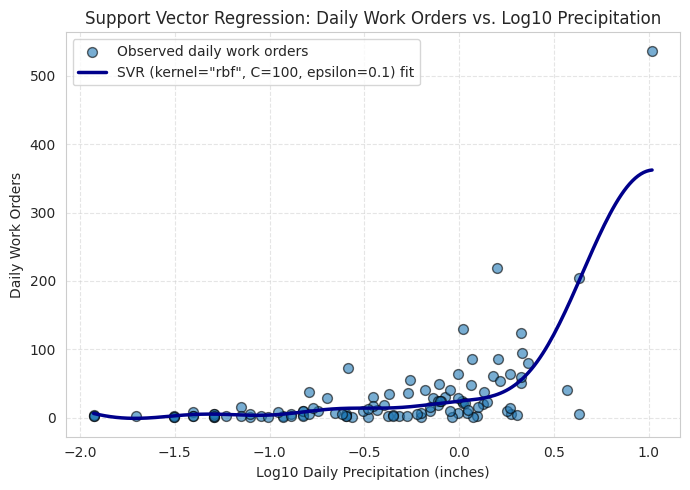

In [88]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#Feature Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

#Reshape X_train, X_test, y_train, y_test for scaling
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

#SVR Model Initialization and Training
#(gamma for 'rbf' kernel)
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale', cache_size=500) #Using 'rbf' kernel for non-linearity
svr_model.fit(X_train_scaled, y_train_scaled)

#Predictions
y_train_pred_scaled = svr_model.predict(X_train_scaled)
y_test_pred_scaled = svr_model.predict(X_test_scaled)

#Inverse transform predictions to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

#Performance Metrics
rmse_train_svr = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train_svr = r2_score(y_train, y_train_pred)
r2_test_svr = r2_score(y_test, y_test_pred)

print("===== Support Vector Regression (SVR) =====")
print(f"Training RMSE: {rmse_train_svr:.3f}")
print(f"Testing RMSE:  {rmse_test_svr:.3f}")
print(f"Training R²:   {r2_train_svr:.3f}")
print(f"Testing R²:    {r2_test_svr:.3f}")

#Visualization
x_plot = np.linspace(model_df['log10_PRCP_in'].min(), model_df['log10_PRCP_in'].max(), 200).reshape(-1, 1)
x_plot_scaled = scaler_X.transform(x_plot)
y_plot_svr_scaled = svr_model.predict(x_plot_scaled)
y_plot_svr = scaler_y.inverse_transform(y_plot_svr_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(7, 5))
plt.scatter(
    model_df['log10_PRCP_in'],
    model_df['daily_work_orders'],
    alpha=0.6,
    edgecolor='k',
    s=50,
    label='Observed daily work orders'
)
plt.plot(
    x_plot,
    y_plot_svr,
    color='darkblue',
    linewidth=2.5,
    label=f'SVR (kernel="rbf", C={svr_model.C}, epsilon={svr_model.epsilon}) fit'
)
plt.title('Support Vector Regression: Daily Work Orders vs. Log10 Precipitation')
plt.xlabel('Log10 Daily Precipitation (inches)')
plt.ylabel('Daily Work Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()